In [2]:
import json
import pandas as pd
from typing import TypedDict
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, spearmanr,pearsonr,  mannwhitneyu, wilcoxon, ttest_rel

In [3]:
raw_data_json_path = '/home/artem/Projects/Psycat/data.json'
with open(raw_data_json_path, 'r') as rf:
    data = json.load(rf)

len(data.keys())

33

In [4]:
data_f1 = {}

for key in data:
    if  data[key].get('gilbert_test_passed') == 'yes': 
        data_f1[key] = data[key]



In [5]:
class GilbertSeries(TypedDict):
    ans_a: int
    mean_a: float
    std_a: float
    mean_r: float
    ans_r: float
    std_r: float
    mean_l: float
    ans_l: float
    std_l: float
    ground: str
    target: str
    figure: str


class StroopSeries(TypedDict):
    count_a: int
    mean_a: float
    std_a: float
    count_r: float
    mean_r: float
    std_r: float
    count_l: float
    mean_l: float
    std_l: float


class RowStructure(TypedDict):
    code: str
    name: str
    datetime: datetime
    gilbert_test_results: list[GilbertSeries]
    stroop_test_results: list[StroopSeries]

print(data_f1['069632:bold_wheat_elephant']['gilbert_test_results'][0]['tests'][0])

{'reaction_time': 549, 'answer': 'r', 'direction': 'r', 'position': 3, 'correctly': True}


In [6]:
colors = {
    '#b2b2b2': 'back',
    '#929292': 'grey',
    '#000000': 'black',

    'color(display-p3 0.9111 0.2904 0.3331)': 'r',
    'color(display-p3 0.8886 0.2848 0.5066)': 'red-in-pink',
    'color(display-p3 0.907 0.3246 0.0816)': 'red-out-orange',

    'color(display-p3 0.8675 0.7351 0.0446)': 'y',
    'color(display-p3 0.9686 0.67 0.1156)': 'yellow-in-orange',
    'color(display-p3 0.7347 0.7951 0.2312)': 'yellow-out-green',

    'color(display-p3 0.0772 0.7146 0.7601)': 'b',
    'color(display-p3 0.2086 0.6784 0.8873)': 'blue-in-violet',
    'color(display-p3 0.2336 0.727 0.5989)': 'blue-out-green',

}

332301 - девушка с гемеопсией (слепая на левое поле зрения) 20.04
241793, 500116 - Илья 17.04, 24.04
620528, 758625 - девушка с депрессией 24.04

346921 - дальтоник 



Обнаружено: респонденты чаще ошибаются влево

In [7]:
data_f2: list[RowStructure] = []

removed_persons = ['332301', '241793', '620528', '758625', '346921']

for key in data_f1:
    row = data_f1[key]

    if row['code'] in removed_persons:
        continue

    f_row = {
        'code': row['code'],
        'name': row['uid'],
        # 'stroop_test_results': 'yes' if 'stroop_test_results' in row and row['stroop_test_results'] else 'no',
        'datetime': datetime.fromtimestamp(row['datetime']['seconds']).strftime("%Y-%m-%d %H:%M:%S")
    }

    series = row['gilbert_test_results'][0]

    probes_a = []
    for probe in series['tests'][1:]:
        if probe['correctly']:
            probes_a.append(probe['reaction_time'])

    reaction = np.mean(probes_a)

    f_row['reaction'] = reaction


    probes_stroop_a = []

    for probe in row['stroop_test_results']:
        if not probe['correctly']:
            continue
        reaction_time = probe['reaction_time']

        probes_stroop_a.append(reaction_time)

    f_row["stroop"] = np.mean(probes_stroop_a)


    index = 1

    for series in row['gilbert_test_results'][1:]:

        probes_a = []
        probes_r = []
        probes_l = []

        for probe in series['tests'][1:]:
            if not probe['correctly']:
                continue
            reaction_time = probe['reaction_time']
            if reaction_time > 1000:
                continue

            # reaction_time -= reaction

            probes_a.append(reaction_time)
            if probe['direction'] == 'r':
                probes_r.append(reaction_time)
            else:
                probes_l.append(reaction_time)

        key = f"{colors[series['ground']]}_{series['figure']}_{'in' if 'in' in colors[series['target']] else 'out'}"

        # if len(probes_a) < 11:
        #     print(len(probes_a),len(probes_l),len(probes_r))

        f_row[f"{index}_{key}"] = len(probes_a)
        f_row[f"cL_{key}"] = len(probes_l)
        f_row[f"cR_{key}"] = len(probes_r)
        f_row[f"A_{key}"] = np.mean(probes_a)
        f_row[f"L_{key}"] = np.mean(probes_l)
        f_row[f"R_{key}"] = np.mean(probes_r)
        f_row[f"A_std_{key}"] = np.std(probes_a)
        f_row[f"L_std_{key}"] = np.std(probes_l)
        f_row[f"R_std_{key}"] = np.std(probes_r)


        index += 1

    

    # f_row[f"R_st_count"] = len(probes_stroop_r)
    # f_row[f"R_st_std"] = np.std(probes_stroop_r)
    # f_row[f"R_st_mean"] = np.mean(probes_stroop_r)
    # f_row[f"L_st_count"] = len(probes_stroop_l)
    # f_row[f"L_st_std"] = np.std(probes_stroop_l)
    # f_row[f"L_st_mean"] = np.mean(probes_stroop_l)



    data_f2.append(f_row)

resp_count = len(data_f2)

full_table = pd.DataFrame(data_f2)

In [8]:
# tests = data_f1['090088:carefree_alizarin_starfish']['gilbert_test_results'][2]['tests']
# pd.DataFrame(tests)

# tests = data_f1['392274:foolish_chartreuse_pigeon']['stroop_test_results']
# pd.DataFrame(tests)


In [9]:
client = data_f2[10]
print('code', client['code'])
print('name', client['name'])
print('datetime', client['datetime'])
print('reaction', client['reaction'])


# {'in': }


code 392274
name foolish_chartreuse_pigeon
datetime 2024-05-22 12:06:50
reaction 444.0


In [10]:
# full_table

In [11]:
full_table.to_csv('table.csv', float_format="%.8f")

In [12]:
full_table.keys()

Index(['code', 'name', 'datetime', 'reaction', 'stroop', '1_r_square_in',
       'cL_r_square_in', 'cR_r_square_in', 'A_r_square_in', 'L_r_square_in',
       ...
       'R_std_b_blob_in', '12_b_blob_out', 'cL_b_blob_out', 'cR_b_blob_out',
       'A_b_blob_out', 'L_b_blob_out', 'R_b_blob_out', 'A_std_b_blob_out',
       'L_std_b_blob_out', 'R_std_b_blob_out'],
      dtype='object', length=113)

In [13]:
full_table[['reaction', 'A_r_square_in', 'L_r_square_in',
       'R_r_square_in', 
       'A_r_square_out', 'L_r_square_out', 'R_r_square_out', 'A_r_heart_in', 'L_r_heart_in',
       'R_r_heart_in', 
       'A_r_heart_out', 'L_r_heart_out', 'R_r_heart_out',  'A_y_square_in', 'L_y_square_in',
       'R_y_square_in', 
       'A_y_square_out', 'L_y_square_out', 'R_y_square_out',  'A_y_sun_in', 'L_y_sun_in', 'R_y_sun_in',
        'A_y_sun_out',
       'L_y_sun_out', 'R_y_sun_out',  'A_b_square_in', 'L_b_square_in', 'R_b_square_in',
       'A_b_square_out', 'L_b_square_out', 'R_b_square_out',  'A_b_blob_in', 'L_b_blob_in',
       'R_b_blob_in', 
       'A_b_blob_out', 'L_b_blob_out', 'R_b_blob_out']].mean().to_dict()

{'reaction': 496.4607843137254,
 'A_r_square_in': 526.8663101604278,
 'L_r_square_in': 529.3941176470589,
 'R_r_square_in': 524.3372549019608,
 'A_r_square_out': 543.632219251337,
 'L_r_square_out': 545.5333333333334,
 'R_r_square_out': 542.1049019607844,
 'A_r_heart_in': 508.3089126559714,
 'L_r_heart_in': 511.54411764705884,
 'R_r_heart_in': 505.1627450980392,
 'A_r_heart_out': 531.3533868092693,
 'L_r_heart_out': 545.3235294117648,
 'R_r_heart_out': 517.9019607843137,
 'A_y_square_in': 626.8295454545454,
 'L_y_square_in': 623.7460784313726,
 'R_y_square_in': 630.927450980392,
 'A_y_square_out': 512.4509803921568,
 'L_y_square_out': 512.256862745098,
 'R_y_square_out': 511.44313725490196,
 'A_y_sun_in': 557.816577540107,
 'L_y_sun_in': 549.7686274509804,
 'R_y_sun_in': 565.2627450980391,
 'A_y_sun_out': 509.8712121212121,
 'L_y_sun_out': 520.1647058823529,
 'R_y_sun_out': 499.62549019607843,
 'A_b_square_in': 643.0975341651812,
 'L_b_square_in': 651.15,
 'R_b_square_in': 641.70392156

В всех случаях пиктограммы, в среднем, распознаются лучше!

Межкатегориальные распознаются лучше, кроме красного

Почти всюду правый глаз быстрее

In [14]:
full_table['A_r_square_in'].to_numpy()

array([536.91666667, 564.36363636, 474.83333333, 525.25      ,
       500.58333333, 579.75      , 623.66666667, 489.        ,
       421.36363636, 543.83333333, 479.58333333, 502.58333333,
       491.58333333, 455.33333333, 668.5       , 527.91666667,
       571.66666667])

In [15]:
res = np.zeros((3,3,2,2, resp_count))

stroop_res = full_table["stroop"].to_numpy()
reaction_res = full_table["reaction"].to_numpy()

res[0,0,0,0,:] = full_table['A_r_square_in'].to_numpy()
res[1,0,0,0,:] = full_table['R_r_square_in'].to_numpy()
res[2,0,0,0,:] = full_table['L_r_square_in'].to_numpy()

res[0,0,0,1,:] = full_table['A_r_square_out'].to_numpy()
res[1,0,0,1,:] = full_table['R_r_square_out'].to_numpy()
res[2,0,0,1,:] = full_table['L_r_square_out'].to_numpy()


res[0,0,1,0,:] = full_table['A_r_heart_in'].to_numpy()
res[1,0,1,0,:] = full_table['R_r_heart_in'].to_numpy()
res[2,0,1,0,:] = full_table['L_r_heart_in'].to_numpy()

res[0,0,1,1,:] = full_table['A_r_heart_out'].to_numpy()
res[1,0,1,1,:] = full_table['R_r_heart_out'].to_numpy()
res[2,0,1,1,:] = full_table['L_r_heart_out'].to_numpy()


res[0,1,0,0,:] = full_table['A_y_square_in'].to_numpy()
res[1,1,0,0,:] = full_table['R_y_square_in'].to_numpy()
res[2,1,0,0,:] = full_table['L_y_square_in'].to_numpy()

res[0,1,0,1,:] = full_table['A_y_square_out'].to_numpy()
res[1,1,0,1,:] = full_table['R_y_square_out'].to_numpy()
res[2,1,0,1,:] = full_table['L_y_square_out'].to_numpy()


res[0,1,1,0,:] = full_table['A_y_sun_in'].to_numpy()
res[1,1,1,0,:] = full_table['R_y_sun_in'].to_numpy()
res[2,1,1,0,:] = full_table['L_y_sun_in'].to_numpy()

res[0,1,1,1,:] = full_table['A_y_sun_out'].to_numpy()
res[1,1,1,1,:] = full_table['R_y_sun_out'].to_numpy()
res[2,1,1,1,:] = full_table['L_y_sun_out'].to_numpy()


res[0,2,0,0,:] = full_table['A_b_square_in'].to_numpy()
res[1,2,0,0,:] = full_table['R_b_square_in'].to_numpy()
res[2,2,0,0,:] = full_table['L_b_square_in'].to_numpy()

res[0,2,0,1,:] = full_table['A_b_square_out'].to_numpy()
res[1,2,0,1,:] = full_table['R_b_square_out'].to_numpy()
res[2,2,0,1,:] = full_table['L_b_square_out'].to_numpy()


res[0,2,1,0,:] = full_table['A_b_blob_in'].to_numpy()
res[1,2,1,0,:] = full_table['R_b_blob_in'].to_numpy()
res[2,2,1,0,:] = full_table['L_b_blob_in'].to_numpy()

res[0,2,1,1,:] = full_table['A_b_blob_out'].to_numpy()
res[1,2,1,1,:] = full_table['R_b_blob_out'].to_numpy()
res[2,2,1,1,:] = full_table['L_b_blob_out'].to_numpy()

# res[A-L-R, R-Y-B, sq-fg, in-out,:]

In [16]:
res_std = np.zeros((3,3,2,2, resp_count))

res_std[0,0,0,0,:] = full_table['A_std_r_square_in'].to_numpy()
res_std[1,0,0,0,:] = full_table['R_std_r_square_in'].to_numpy()
res_std[2,0,0,0,:] = full_table['L_std_r_square_in'].to_numpy()

res_std[0,0,0,1,:] = full_table['A_std_r_square_out'].to_numpy()
res_std[1,0,0,1,:] = full_table['R_std_r_square_out'].to_numpy()
res_std[2,0,0,1,:] = full_table['L_std_r_square_out'].to_numpy()


res_std[0,0,1,0,:] = full_table['A_std_r_heart_in'].to_numpy()
res_std[1,0,1,0,:] = full_table['R_std_r_heart_in'].to_numpy()
res_std[2,0,1,0,:] = full_table['L_std_r_heart_in'].to_numpy()

res_std[0,0,1,1,:] = full_table['A_std_r_heart_out'].to_numpy()
res_std[1,0,1,1,:] = full_table['R_std_r_heart_out'].to_numpy()
res_std[2,0,1,1,:] = full_table['L_std_r_heart_out'].to_numpy()


res_std[0,1,0,0,:] = full_table['A_std_y_square_in'].to_numpy()
res_std[1,1,0,0,:] = full_table['R_std_y_square_in'].to_numpy()
res_std[2,1,0,0,:] = full_table['L_std_y_square_in'].to_numpy()

res_std[0,1,0,1,:] = full_table['A_std_y_square_out'].to_numpy()
res_std[1,1,0,1,:] = full_table['R_std_y_square_out'].to_numpy()
res_std[2,1,0,1,:] = full_table['L_std_y_square_out'].to_numpy()


res_std[0,1,1,0,:] = full_table['A_std_y_sun_in'].to_numpy()
res_std[1,1,1,0,:] = full_table['R_std_y_sun_in'].to_numpy()
res_std[2,1,1,0,:] = full_table['L_std_y_sun_in'].to_numpy()

res_std[0,1,1,1,:] = full_table['A_std_y_sun_out'].to_numpy()
res_std[1,1,1,1,:] = full_table['R_std_y_sun_out'].to_numpy()
res_std[2,1,1,1,:] = full_table['L_std_y_sun_out'].to_numpy()


res_std[0,2,0,0,:] = full_table['A_std_b_square_in'].to_numpy()
res_std[1,2,0,0,:] = full_table['R_std_b_square_in'].to_numpy()
res_std[2,2,0,0,:] = full_table['L_std_b_square_in'].to_numpy()

res_std[0,2,0,1,:] = full_table['A_std_b_square_out'].to_numpy()
res_std[1,2,0,1,:] = full_table['R_std_b_square_out'].to_numpy()
res_std[2,2,0,1,:] = full_table['L_std_b_square_out'].to_numpy()


res_std[0,2,1,0,:] = full_table['A_std_b_blob_in'].to_numpy()
res_std[1,2,1,0,:] = full_table['R_std_b_blob_in'].to_numpy()
res_std[2,2,1,0,:] = full_table['L_std_b_blob_in'].to_numpy()

res_std[0,2,1,1,:] = full_table['A_std_b_blob_out'].to_numpy()
res_std[1,2,1,1,:] = full_table['R_std_b_blob_out'].to_numpy()
res_std[2,2,1,1,:] = full_table['L_std_b_blob_out'].to_numpy()

Переключаемость внимания влияет на скорость реакции

In [17]:
stroop_res

array([ 954.625     ,  849.66666667, 1204.95652174,  912.5       ,
        739.83333333,  898.60869565, 1073.69565217, 1009.13043478,
        623.70833333, 1151.38095238, 1327.        ,  905.875     ,
        708.375     ,  863.5       , 1394.70833333, 1824.04545455,
        929.04166667])

In [18]:
res[0,0,0,0,:]

array([536.91666667, 564.36363636, 474.83333333, 525.25      ,
       500.58333333, 579.75      , 623.66666667, 489.        ,
       421.36363636, 543.83333333, 479.58333333, 502.58333333,
       491.58333333, 455.33333333, 668.5       , 527.91666667,
       571.66666667])

In [19]:

print(pearsonr(stroop_res,
    (res[0,0,0,0,:]+res[0,0,0,1,:]+res[0,0,1,0,:]+res[0,0,1,1,:]+
    res[0,1,0,0,:]+res[0,1,0,1,:]+res[0,1,1,0,:]+res[0,1,1,1,:]+
    res[0,2,0,0,:]+res[0,2,0,1,:]+res[0,2,1,0,:]+res[0,2,1,1,:])/12
))

print(pearsonr(stroop_res,
    res[0,0,0,0,:]+res[0,0,0,1,:]+
    res[0,1,0,0,:]+res[0,1,0,1,:]+
    res[0,2,0,0,:]+res[0,2,0,1,:]
))


print(pearsonr(stroop_res,
    res[0,0,1,0,:]+res[0,0,1,1,:]+
    res[0,1,1,0,:]+res[0,1,1,1,:]+
    res[0,2,1,0,:]+res[0,2,1,1,:]
))


PearsonRResult(statistic=0.5615970308552092, pvalue=0.01897982162415529)
PearsonRResult(statistic=0.4745745800750896, pvalue=0.054250614420144685)
PearsonRResult(statistic=0.6090866618314407, pvalue=0.009453238511259001)


In [20]:

def tcriteria(a,b):
    return {
        's': ttest_rel(a,b).statistic,
        'w':wilcoxon(a,b).pvalue,
        't':ttest_rel(a,b).pvalue,
    }



In [42]:
""" право-лево, цвет, кв-фиг, вкат-межкат"""

print(
    tcriteria(
        res[0,:,0,:,:].flatten(), 
        res[0,:,1,:,:].flatten()
    ),
)

print(
    tcriteria(
        res[0,:,0,:,:].mean((0,1)).flatten(), 
        res[0,:,1,:,:].mean((0,1)).flatten()
    ),
)

print(
    tcriteria(
        res[0,0,:,0,:].mean(0).flatten(), 
        res[0,0,:,1,:].mean(0).flatten()
    ),
)

print(
    tcriteria(
        res[0,1,:,0,:].mean(0).flatten(), 
        res[0,1,:,1,:].mean(0).flatten()
    ),
)

print(
    tcriteria(
        res[0,2,:,0,:].mean(0).flatten(), 
        res[0,2,:,1,:].mean(0).flatten()
    ),
)




{'s': 4.269690504726968, 'w': 1.438045546282436e-05, 't': 4.4293425861560626e-05}
{'s': 3.3936684368563843, 'w': 0.00665283203125, 't': 0.0037093932850901655}
{'s': -1.903764120861477, 'w': 0.1323699951171875, 't': 0.07508621649692776}
{'s': 11.977644391392257, 'w': 1.52587890625e-05, 't': 2.1137948464969214e-09}
{'s': 8.3486316179181, 'w': 1.52587890625e-05, 't': 3.174751750373133e-07}


In [41]:
""" право-лево, цвет, кв-фиг, вкат-межкат"""

print(
    tcriteria(
        res[1,:,1,:].mean((0,1)).flatten(), 
        res[2,:,1,:].mean((0,1)).flatten()
    ),
)


# print(
#     tcriteria(
#         res[1,:,:,0].flatten(), 
#         res[2,:,:,1].flatten()
#     ),
# )


# print(
#     tcriteria(
#         res[1,:,:,0].flatten(), 
#         res[2,:,:,1].flatten()
#     ),
# )


{'s': -3.146036233334566, 'w': 0.007904052734375, 't': 0.006246938333624241}


In [23]:
np.mean(res[0,:,0,:], axis=(-1))

array([[526.86631016, 543.63221925],
       [626.82954545, 512.45098039],
       [643.09753417, 528.58868093]])

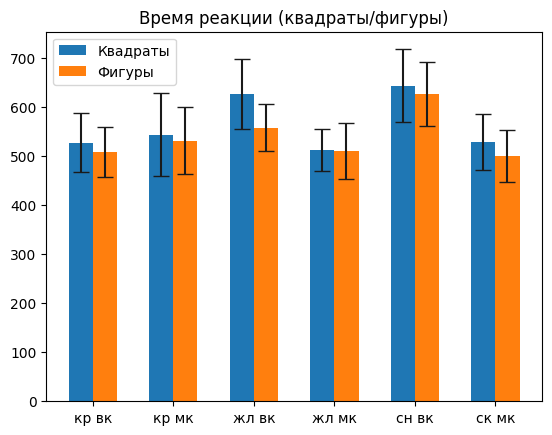

In [24]:
""" право-лево, цвет, кв-фиг, вкат-межкат"""

cols_names = ['кр вк', 'кр мк', 'жл вк', 'жл мк', 'сн вк', 'ск мк']

color = 2
values_mean_l = np.mean(res[0,:,0,:], axis=(-1)).flatten()
values_std_l = np.std(  res[0,:,0,:], axis=(-1)).flatten()

values_mean_r = np.mean(res[0,:,1,:], axis=(-1)).flatten()
values_std_r = np.std(  res[0,:,1,:], axis=(-1)).flatten()

width = 0.3
x = np.arange(len(cols_names))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_mean_l, width, yerr=values_std_l, error_kw={'ecolor':'0.1','capsize':6}, label='Квадраты')
rects2 = ax.bar(x + width/2, values_mean_r, width, yerr=values_std_r, error_kw={'ecolor':'0.1','capsize':6}, label='Фигуры')
ax.set_title('Время реакции (квадраты/фигуры)')
ax.set_xticks(x)
ax.set_xticklabels(cols_names)
ax.legend()

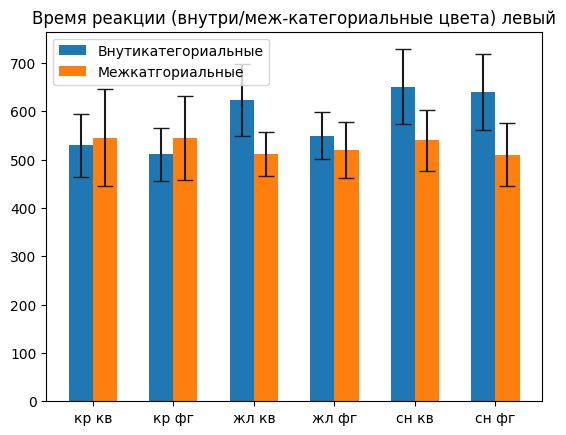

In [25]:
""" право-лево, цвет, кв-фиг, вкат-межкат"""

cols_names = ['кр кв', 'кр фг', 'жл кв', 'жл фг', 'сн кв', 'сн фг']

color = 2
values_mean_l = np.mean(res[2,:,:,0], axis=(-1)).flatten()
values_std_l = np.std(  res[2,:,:,0], axis=(-1)).flatten()

values_mean_r = np.mean(res[2,:,:,1], axis=(-1)).flatten()
values_std_r = np.std(  res[2,:,:,1], axis=(-1)).flatten()

width = 0.3
x = np.arange(len(cols_names))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_mean_l, width, yerr=values_std_l, error_kw={'ecolor':'0.1','capsize':6}, label='Внутикатегориальные')
rects2 = ax.bar(x + width/2, values_mean_r, width, yerr=values_std_r, error_kw={'ecolor':'0.1','capsize':6}, label='Межкатгориальные')
ax.set_title('Время реакции (внутри/меж-категориальные цвета) левый')
ax.set_xticks(x)
ax.set_xticklabels(cols_names)
ax.legend()

[511.54411765 545.32352941 549.76862745 520.16470588 639.16960784
 510.64705882]
[505.1627451  517.90196078 565.2627451  499.6254902  611.57352941
 490.03137255]


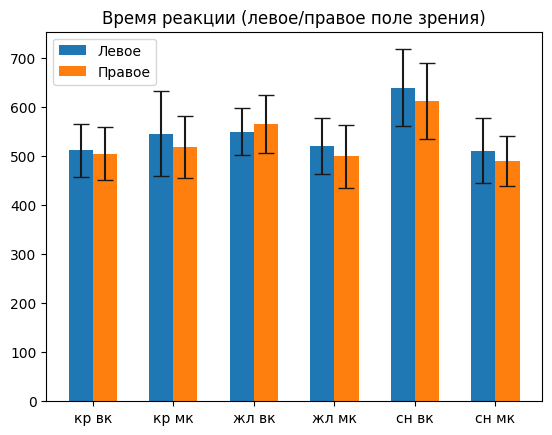

In [26]:
""" право-лево, цвет, кв-фиг, вкат-межкат"""

cols_names = [
    'кр вк','кр мк',
    'жл вк','жл мк', 
    'сн вк', 'сн мк']

color = 2
values_mean_l = np.mean(res[2,:,1,:], axis=(-1)).flatten()
values_std_l = np.std(  res[2,:,1,:], axis=(-1)).flatten()

values_mean_r = np.mean(res[1,:,1,:], axis=(-1)).flatten()
values_std_r = np.std(  res[1,:,1,:], axis=(-1)).flatten()

print(values_mean_l )
print(values_mean_r)

width = 0.3
x = np.arange(len(cols_names))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_mean_l, width, yerr=values_std_l,  error_kw={'ecolor':'0.1','capsize':6}, label='Левое')
rects2 = ax.bar(x + width/2, values_mean_r, width, yerr=values_std_r, error_kw={'ecolor':'0.1','capsize':6}, label='Правое')
ax.set_title('Время реакции (левое/правое поле зрения)')
ax.set_xticks(x)
ax.set_xticklabels(cols_names)
ax.legend()

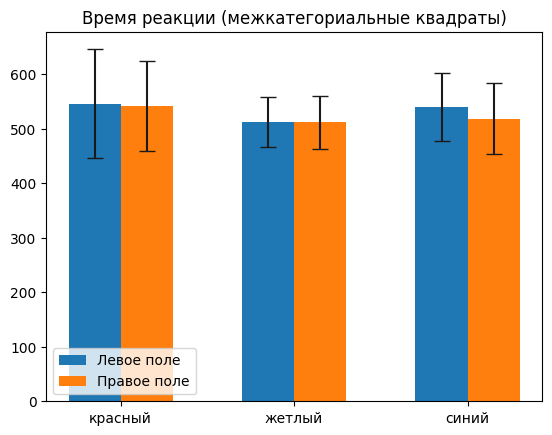

In [27]:
""" право-лево, цвет, кв-фиг, вкат-межкат"""

cols_names = [
    'красный','жетлый',
    'синий']

color = 2
values_mean_l = np.mean(res[2,:,0,1], axis=(-1)).flatten()
values_std_l = np.std(  res[2,:,0,1], axis=(-1)).flatten()

values_mean_r = np.mean(res[1,:,0,1], axis=(-1)).flatten()
values_std_r = np.std(  res[1,:,0,1], axis=(-1)).flatten()

width = 0.3
x = np.arange(len(cols_names))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_mean_l, width, yerr=values_std_l,  error_kw={'ecolor':'0.1','capsize':6}, label='Левое поле')
rects2 = ax.bar(x + width/2, values_mean_r, width, yerr=values_std_r, error_kw={'ecolor':'0.1','capsize':6}, label='Правое поле')
ax.set_title('Время реакции (межкатегориальные квадраты)')
ax.set_xticks(x)
ax.set_xticklabels(cols_names)
ax.legend()

In [28]:
print(
    'Межкатегор и внутрикатегор',
    tcriteria(
        res[1,:,:,:].mean(axis=(1,2)).flatten(), 
        res[2,:,:,:].mean(axis=(1,2)).flatten()
    )
)


Межкатегор и внутрикатегор {'s': -2.3374691637938385, 'w': 0.04101129696419458, 't': 0.02345890023041717}


In [29]:

print(
    wilcoxon(
        res[1,:,:,:].mean(axis=(1)).flatten(), 
        res[2,:,:,:].mean(axis=(1)).flatten()
    ),
    ttest_rel(
        res[1,:,:,:].mean(axis=(1)).flatten(), 
        res[2,:,:,:].mean(axis=(1)).flatten()
    ),
)

WilcoxonResult(statistic=2020.0, pvalue=0.04290726989635228) TtestResult(statistic=-2.35265666934869, pvalue=0.02057826418325994, df=101)


In [30]:

print(
    'категор в левом на красном',
    wilcoxon(
        res[1,:,:,:,:].flatten(), 
        res[2,:,:,:,:].flatten()
    ),
)

print(
    'категор в правом на красном',
    wilcoxon(
        res[1,0,:,0,:].flatten(), 
        res[1,0,:,1,:].flatten()
    ),
    ttest_rel(
        res[2,0,:,0,:].flatten(), 
        res[2,0,:,1,:].flatten()
    ),
)

print(
    'категор в левом на желтом',
    wilcoxon(
        res[1,1,:,0,:].flatten(), 
        res[1,1,:,1,:].flatten()
    ),
    ttest_rel(
        res[1,1,:,0,:].flatten(), 
        res[1,1,:,1,:].flatten()
    ),
)

print(
    'категор в правом на желтом',
    wilcoxon(
        res[2,1,:,0,:].flatten(), 
        res[2,1,:,1,:].flatten()
    ),
    ttest_rel(
        res[2,1,:,0,:].flatten(), 
        res[2,1,:,1,:].flatten()
    ),    
)

print(
    'категор в левом на синем',
    wilcoxon(
        res[1,2,:,0,:].flatten(), 
        res[1,2,:,1,:].flatten()
    )
)

print(
    'категор в правом на синем',
    wilcoxon(
        res[2,2,:,1,:].flatten(), 
        res[2,2,:,0,:].flatten()
    )
)

ttest_rel

категор в левом на красном WilcoxonResult(statistic=8572.5, pvalue=0.03361566651239679)
категор в правом на красном WilcoxonResult(statistic=226.0, pvalue=0.22799336758907884) TtestResult(statistic=-2.2517528815045322, pvalue=0.03111509064921544, df=33)
категор в левом на желтом WilcoxonResult(statistic=0.0, pvalue=1.1641532182693481e-10) TtestResult(statistic=10.000910714499106, pvalue=1.615283505858155e-11, df=33)
категор в правом на желтом WilcoxonResult(statistic=40.0, pvalue=1.009204424917698e-06) TtestResult(statistic=5.980230724441215, pvalue=1.0224636160614244e-06, df=33)
категор в левом на синем WilcoxonResult(statistic=9.0, pvalue=3.841705620288849e-09)
категор в правом на синем WilcoxonResult(statistic=32.0, pvalue=3.2188836485147476e-07)


<function scipy.stats._stats_py.ttest_rel(a, b, axis=0, nan_policy='propagate', alternative='two-sided', *, keepdims=False)>